## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from random import sample 
from itertools import chain
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from skimage import io
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
55170,00013814_012.png,No Finding,12,13814,65,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_007/images/00013814_012.png
107625,00029081_000.png,No Finding,0,29081,51,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00029081_000.png
75306,00018479_001.png,No Finding,1,18479,47,F,PA,2372,2913,0.143000,0.143000,NaN,/data/images_009/images/00018479_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

for label in all_labels:
    all_xray_df[label] = all_xray_df.apply(lambda x: 1 if label in x['Finding Labels'] else 0, axis= 1)


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['Pneumonia_class'] = all_xray_df.Pneumonia.replace(0,'Neg').replace(1,'Pos')

## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['Pneumonia'])
    # trainging data
 
    pneumonia_inds = train_data[train_data.Pneumonia==1].index.tolist()
 
    no_pneumonia_inds = train_data[train_data.Pneumonia==0].index.tolist()

    

    np_sample = sample(no_pneumonia_inds,len(pneumonia_inds))

    train_data = train_data.loc[pneumonia_inds + np_sample]

    

    pneumonia_inds = val_data[val_data.Pneumonia==1].index.tolist()

    no_pneumonia_inds = val_data[val_data.Pneumonia==0].index.tolist()


    np_sample = sample(no_pneumonia_inds,4*len(pneumonia_inds))

    val_data = val_data.loc[pneumonia_inds + np_sample]
    
    return train_data, val_data

In [6]:
train_df, valid_df = create_splits(all_xray_df)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
def my_image_augmentation():
    my_idg = ImageDataGenerator(featurewise_center=True,
                                featurewise_std_normalization=True,
                                rescale=1. / 255.0,
                                horizontal_flip = True, 
                                shear_range = 0.2,
                                zoom_range=0.2)
    
    return my_idg

train_idg = my_image_augmentation()

train_idg.fit(train_df)???

def my_val_image_augmentation():
    my_idg = ImageDataGenerator(featurewise_center=True,
                                featurewise_std_normalization=True,
                                rescale=1. / 255.0)
    return my_idg

val_idg = my_val_image_augmentation()

val_idg.fit(valid_df)???

def make_train_gen(my_train_idg,train_df):   
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'Pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 16
                                          )
    return train_gen

train_gen = make_train_gen(train_idg,train_df)

def make_val_gen(my_val_idg,val_data):
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224,224), 
                                              batch_size = 32) 

    return val_gen
val_gen = make_val_gen(val_idg,valid_df)

def preprocess_image(imgs,img_mean,img_std,img_size): 
    for batch in imgs:
        for img in batch:
            img = (img - img_mean)/img_std
            img =  resize(img, img_size, anti_aliasing=True)
    return imgs

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [11]:
train_gen[0][0]

array([[[[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784]],

        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784]],

        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784]],

        ...,

        [[0.5088618 , 0.5088618 , 0.5088618 ],
         [0.5160978 , 0.5160978 , 0.5160978 ]

In [12]:
t_x, t_y = next(train_gen)
print('Train', t_x.min(), t_x.max(), t_x.mean(), t_x.std())

Train 0.0 1.0 0.52138 0.24788977


In [ ]:
IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean = 0.489# loads the mean image value they used during training preprocessing
img_std = 0.25#
img_proc = preprocess_image(np.array(train_gen),img_mean,img_std,IMG_SIZE)

In [17]:
train_gen[0][0]

array([[[[1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         [1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         [1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         [1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         [1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         [1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         [1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [

In [ ]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

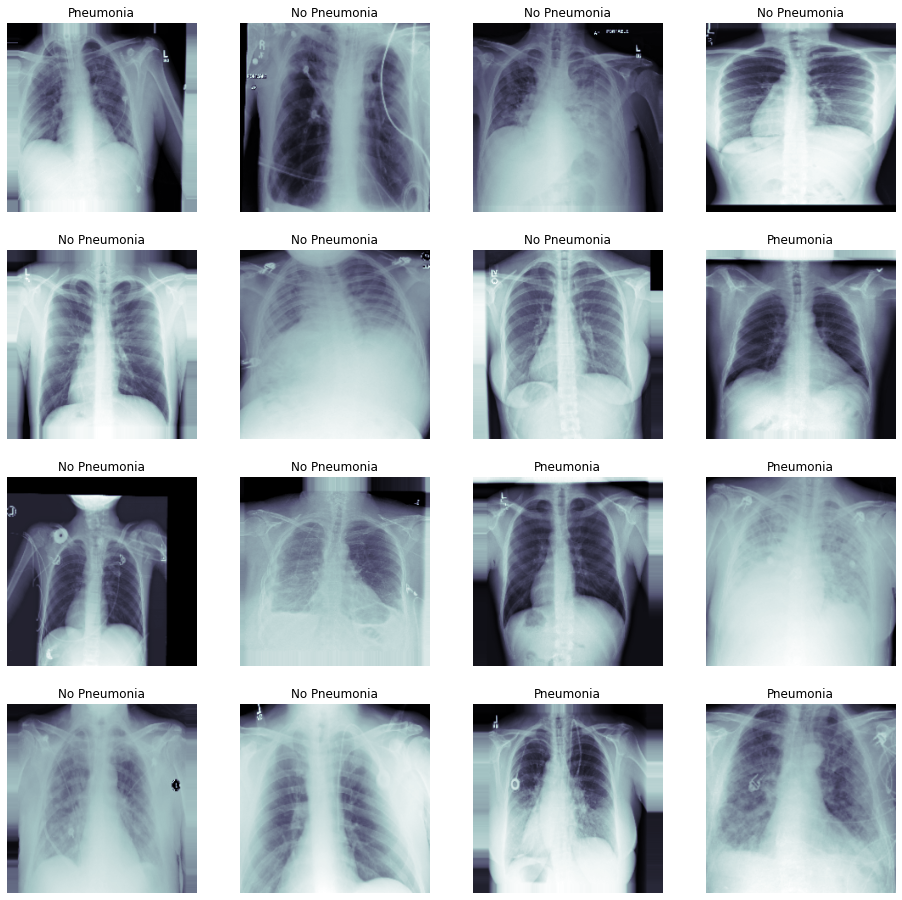

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

    # Todo
    
    return vgg_model
vgg_model = load_pretrained_model()

553467904/553467096 [==============================] - 7s 0us/step


In [14]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
def build_my_model(pretrained_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    for layer in pretrained_model.layers[0:17]:
        layer.trainable = False
        
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    #my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation='relu'))
    #my_model.add(MaxPooling2D(pool_size=(2, 2)))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    #my_model.add(MaxPooling2D(pool_size=(2, 2)))
    my_model.add(Dropout(0.5))
    #my_model.add(Dense(256, activation='relu'))
    #my_model.add(MaxPooling2D(pool_size=(2, 2)))
    my_model.add(Dense(1, activation='sigmoid'))
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model


my_model = build_my_model(vgg_model)
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [ ]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'auto', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'auto', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [ ]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 20, 
                           callbacks = callbacks_list)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 65, verbose = True)

32/32 [==============================] - 3s 107ms/step


In [17]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')


# def ...
# Todo
# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    # Todo
    return

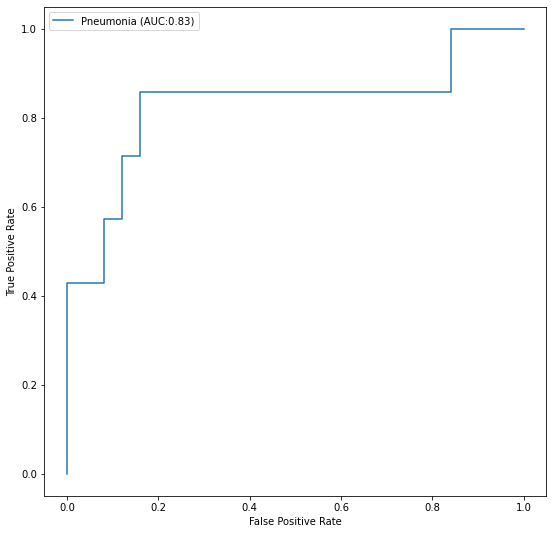

In [18]:
## plot figures

# Todo
plot_auc(valY,pred_Y)

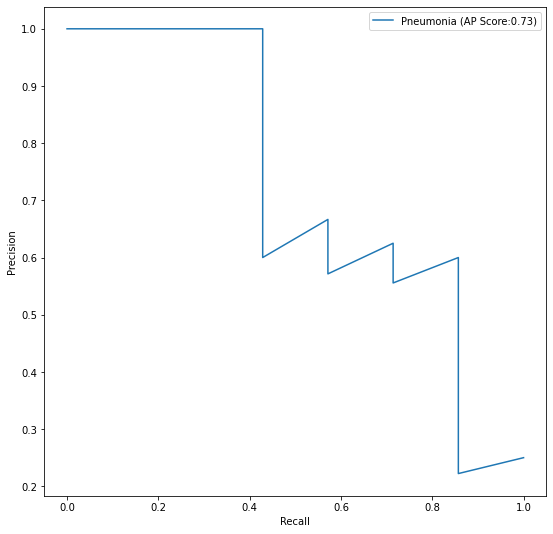

In [19]:
plot_precision_recall_curve(valY,pred_Y)

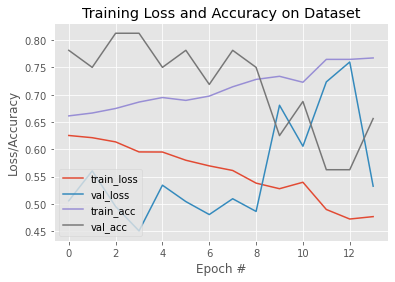

In [20]:
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [22]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y) 
F1_scores = calc_f1(precision, recall)

In [12]:
plot_precision_recall_curve(valY,pred_Y)
plot(thresholds,F1_scores)

NameError: name 'pred_Y' is not defined

In [24]:
max_F1_score = np.max(F1_scores)
max_F1_score

0.7058823529411764

In [25]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY,pred_Y)
precision_value = 0.6
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.6
Recall is: 0.8571428571428571
Threshold is: 0.4858345
F1 Score is: 0.7058823529411764


In [26]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.2222222222222222
Recall is: 0.8571428571428571
Threshold is: 0.15320237
F1 Score is: 0.35294117647058826


In [33]:
probs = pred_Y
t1 = pd.DataFrame((probs > 0.48))
t2 = pd.DataFrame((probs > 0.15))

In [34]:
t1 = t1.replace(True,1).replace(False,0)
t2 = t2.replace(True,1).replace(False,0)

In [42]:
compare_t1 = (t1.T == valY)
compare_t2 = (t2.T == valY)

In [72]:
print('Accuracy at threshold 1: ' + str(compare_t1.T[0].value_counts().loc[True]/len(valX)))

Accuracy at threshold 1: 0.84375


In [73]:
print('Accuracy at threshold 2: ' + str(compare_t2.T[0].value_counts().loc[True]/len(valX)))

Accuracy at threshold 1: 0.3125


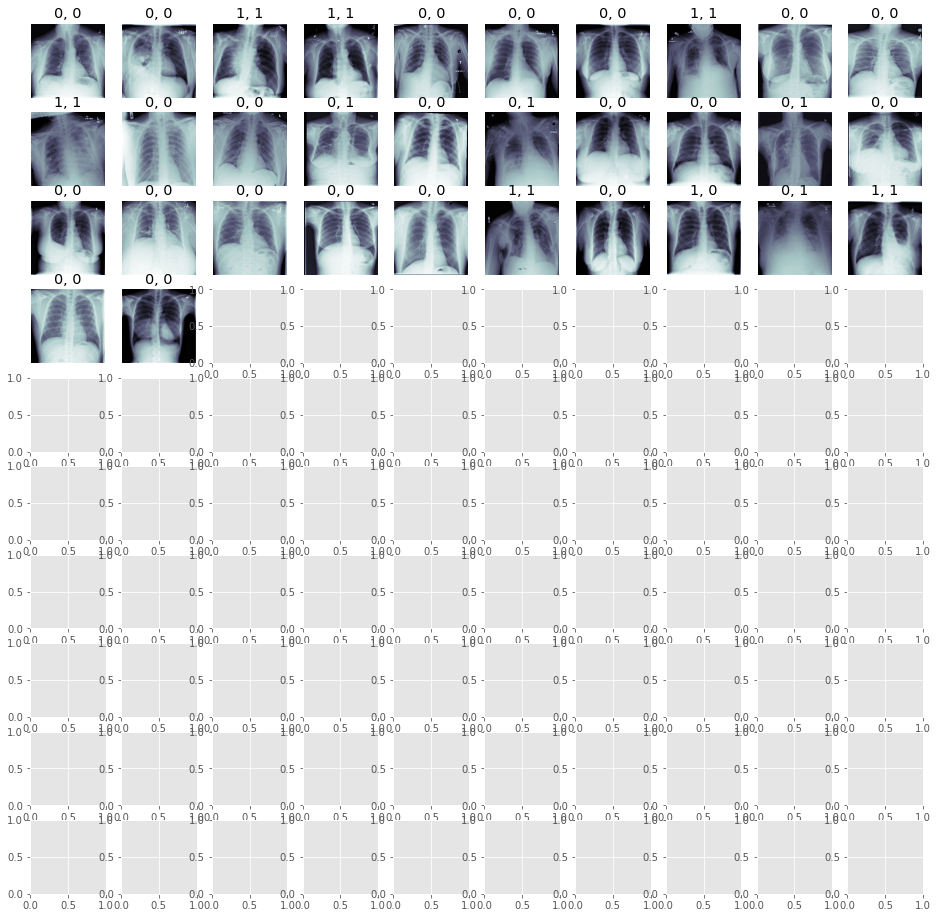

In [75]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.48:
             c_ax.set_title('1, 1')
        else:
             c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.48: 
             c_ax.set_title('0, 1')
        else:
             c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [76]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)